In [1]:
import torch
from torch.utils.data import DataLoader
from torch.optim import SGD ,AdamW

from datasets import load_dataset, load_metric

import matplotlib.pyplot as plt

import json
from statistics import mean

In [2]:
import utils_generic as generic
import multitask_simple as mt
import model_confs as confs
import train

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
tasks = ['to','as','about']

In [4]:
model_conf = confs.bert_conf

# Datos ConvAI

In [5]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [6]:
convai_train = data['train']
convai_val = data['validation']



convai_train_token = generic.tokenize_dataset(convai_train,tasks,model_conf) 
convai_val_token = generic.tokenize_dataset(convai_val,tasks,model_conf) 

In [7]:
convai_train_dataset = mt.DatasetMultiTaskSimple(convai_train_token,tasks,eval=False)
convai_val_dataset = mt.DatasetMultiTaskSimple(convai_val_token,tasks,eval=False)

# Datos md_gender

In [8]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [9]:
md_tokenized = generic.tokenize_dataset(md_data,tasks,model_conf) 
md_dataset = mt.DatasetMultiTaskSimple(md_tokenized,tasks,eval=True)

# Creación dataloaders

In [10]:
dl_train =DataLoader(convai_train_dataset,batch_size=128,shuffle=True,collate_fn=mt.collate_fn)
dl_val =DataLoader(convai_val_dataset,batch_size=128,shuffle=True,collate_fn=mt.collate_fn)
dl_eval = DataLoader(md_dataset,batch_size=128,shuffle=False,collate_fn=mt.collate_fn)

# Modelo multitask

In [14]:
num_epochs = 100
learning_rate = 1e-6

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 2.0493930202327952 	 Validation loss: 2.0122393692954113 	 
  1%|          | 574/57400 [01:40<2:35:55,  6.07it/s]
Epoch 2 	 Training loss: 1.9935068888946692 	 Validation loss: 1.9915621098825487 	 
  2%|▏         | 1148/57400 [03:17<2:32:49,  6.13it/s]
Epoch 3 	 Training loss: 1.9742581563959554 	 Validation loss: 1.9850804603705972 	 
  3%|▎         | 1722/57400 [04:56<2:28:58,  6.23it/s]
Epoch 4 	 Training loss: 1.9713812707193221 	 Validation loss: 1.9807737419160747 	 
  4%|▍         | 2296/57400 [06:35<2:45:30,  5.55it/s]
Epoch 5 	 Training loss: 1.9652006061234957 	 Validation loss: 1.9725779032303115 	 
  5%|▌         | 2870/57400 [08:13<2:23:21,  6.34it/s]
Epoch 6 	 Training loss: 1.965037179117834 	 Validation loss: 1.9801544658208297 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [09:51<2:29:52,  6.00it/s]
Epoch 7 	 Training loss: 1.9571325662659436 	 Validation loss: 1.9791477777190127 	 

2 epoch without improvement
  7%|▋         | 40

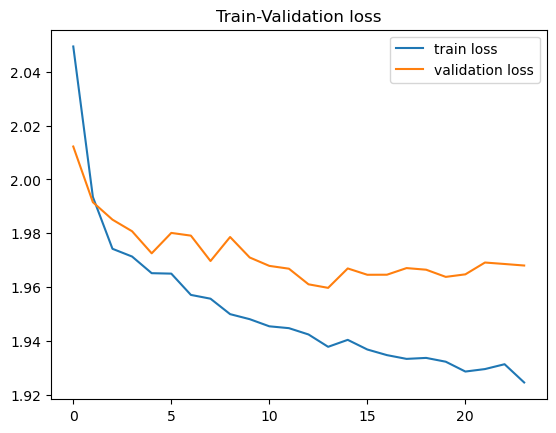

In [12]:
model = mt.MultiTaskSimple(model_conf).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
save_path='bert_multitask_simple_1'
train.train_function_multi(model,num_epochs,dl_train,optimizer,early_stop = 10,dl_val = dl_val,save_path=save_path,es_threshold=0)

In [15]:
model = mt.MultiTaskSimple(model_conf).to(device)
model.load_state_dict(torch.load('bert_multitask_simple_1'))

print("Evaluación del modelo")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender=None)
generic.update_global_metric_multi(result_global,global_metrics,mtype='global')
print(result_global,'\n')
print("Evaluación en etiquetas male")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='male')
generic.update_global_metric_multi(result_global,global_metrics,mtype='male')
print(result_global,'\n')
print("Evaluación en etiquetas female")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='female')
generic.update_global_metric_multi(result_global,global_metrics,mtype='female')
print(result_global,'\n')


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación del modelo
{'to': {'recall': 0.6931818181818182, 'precision': 0.6931818181818182, 'f1': 0.6931818181818182, 'accuracy': 0.6931818181818182}, 'as': {'recall': 0.7327249022164276, 'precision': 0.7327249022164276, 'f1': 0.7327249022164276, 'accuracy': 0.7327249022164276}, 'about': {'recall': 0.8392857142857143, 'precision': 0.8392857142857143, 'f1': 0.8392857142857143, 'accuracy': 0.8392857142857143}} 

Evaluación en etiquetas male
{'to': {'recall': 0.7031630170316302, 'precision': 0.7031630170316302, 'f1': 0.7031630170316302, 'accuracy': 0.7031630170316302}, 'as': {'recall': 0.7247474747474747, 'precision': 0.7247474747474747, 'f1': 0.7247474747474747, 'accuracy': 0.7247474747474747}, 'about': {'recall': 0.8307291666666666, 'precision': 0.8307291666666666, 'f1': 0.8307291666666666, 'accuracy': 0.8307291666666666}} 

Evaluación en etiquetas female
{'to': {'recall': 0.6824146981627297, 'precision': 0.6824146981627297, 'f1': 0.6824146981627297, 'accuracy': 0.6824146981627297}, 'a

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 2.055431701165043 	 Validation loss: 2.0189014026674172 	 
  1%|          | 574/57400 [01:38<2:37:51,  6.00it/s]
Epoch 2 	 Training loss: 1.997565320767592 	 Validation loss: 1.9893328658605025 	 
  2%|▏         | 1148/57400 [03:16<2:31:38,  6.18it/s]
Epoch 3 	 Training loss: 1.9795819346497698 	 Validation loss: 1.984380178532358 	 
  3%|▎         | 1722/57400 [04:55<2:36:28,  5.93it/s]
Epoch 4 	 Training loss: 1.9741082779206465 	 Validation loss: 1.9859263492842851 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [06:33<2:23:34,  6.40it/s]
Epoch 5 	 Training loss: 1.9647476922344247 	 Validation loss: 1.9711830656407243 	 
  5%|▌         | 2870/57400 [08:12<2:21:47,  6.41it/s]
Epoch 6 	 Training loss: 1.9606818656472795 	 Validation loss: 1.973184920973697 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [09:51<2:03:01,  7.31it/s]
Epoch 7 	 Training loss: 1.9579645858409098 	 Validation loss: 1.9730710700406866 	 

2 epoch without impro

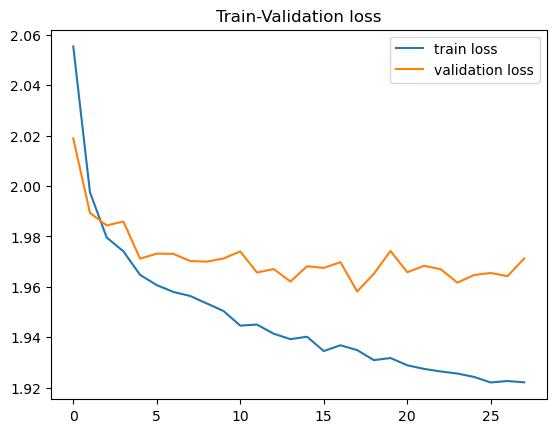

In [14]:
model = mt.MultiTaskSimple(model_conf).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
save_path='bert_multitask_simple_2'
train.train_function_multi(model,num_epochs,dl_train,optimizer,early_stop = 10,dl_val = dl_val,save_path=save_path,es_threshold=0)

In [16]:
model = mt.MultiTaskSimple(model_conf).to(device)
model.load_state_dict(torch.load('bert_multitask_simple_2'))

print("Evaluación del modelo")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender=None)
generic.update_global_metric_multi(result_global,global_metrics,mtype='global')
print(result_global,'\n')
print("Evaluación en etiquetas male")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='male')
generic.update_global_metric_multi(result_global,global_metrics,mtype='male')
print(result_global,'\n')
print("Evaluación en etiquetas female")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='female')
generic.update_global_metric_multi(result_global,global_metrics,mtype='female')
print(result_global,'\n')


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación del modelo
{'to': {'recall': 0.6994949494949495, 'precision': 0.6994949494949495, 'f1': 0.6994949494949495, 'accuracy': 0.6994949494949495}, 'as': {'recall': 0.7327249022164276, 'precision': 0.7327249022164276, 'f1': 0.7327249022164276, 'accuracy': 0.7327249022164276}, 'about': {'recall': 0.8278061224489796, 'precision': 0.8278061224489796, 'f1': 0.8278061224489796, 'accuracy': 0.8278061224489796}} 

Evaluación en etiquetas male
{'to': {'recall': 0.6909975669099757, 'precision': 0.6909975669099757, 'f1': 0.6909975669099757, 'accuracy': 0.6909975669099757}, 'as': {'recall': 0.7222222222222222, 'precision': 0.7222222222222222, 'f1': 0.7222222222222222, 'accuracy': 0.7222222222222222}, 'about': {'recall': 0.8255208333333334, 'precision': 0.8255208333333334, 'f1': 0.8255208333333334, 'accuracy': 0.8255208333333334}} 

Evaluación en etiquetas female
{'to': {'recall': 0.7086614173228346, 'precision': 0.7086614173228346, 'f1': 0.7086614173228346, 'accuracy': 0.7086614173228346}, 'a

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 2.054699756957928 	 Validation loss: 2.0085012730905567 	 
  1%|          | 574/57400 [01:35<2:42:04,  5.84it/s]
Epoch 2 	 Training loss: 1.993545838557054 	 Validation loss: 1.9862983933949874 	 
  2%|▏         | 1148/57400 [03:11<2:25:05,  6.46it/s]
Epoch 3 	 Training loss: 1.9803886060515348 	 Validation loss: 1.9728581460855774 	 
  3%|▎         | 1722/57400 [04:47<2:23:05,  6.49it/s]
Epoch 4 	 Training loss: 1.9708391934737095 	 Validation loss: 1.9694530681028204 	 
  4%|▍         | 2296/57400 [06:23<2:18:21,  6.64it/s]
Epoch 5 	 Training loss: 1.9669206524559846 	 Validation loss: 1.9734104103961234 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [07:59<2:23:50,  6.32it/s]
Epoch 6 	 Training loss: 1.9634525105097569 	 Validation loss: 1.966177518084898 	 
  6%|▌         | 3444/57400 [09:35<2:22:51,  6.29it/s]
Epoch 7 	 Training loss: 1.9584461357120022 	 Validation loss: 1.972114310426227 	 

1 epoch without improvement
  7%|▋         | 4018/

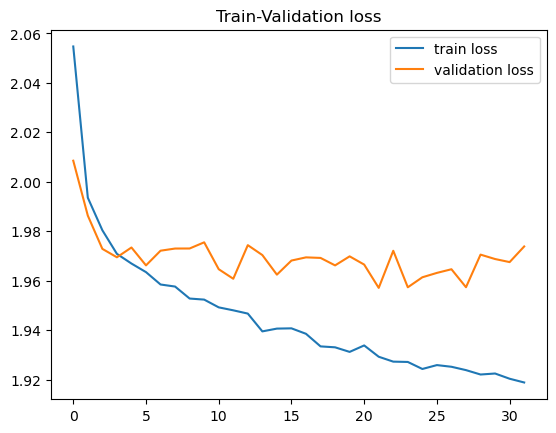

In [15]:
model = mt.MultiTaskSimple(model_conf).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
save_path='bert_multitask_simple_3'
train.train_function_multi(model,num_epochs,dl_train,optimizer,early_stop = 10,dl_val = dl_val,save_path=save_path,es_threshold=0)

In [17]:
model = mt.MultiTaskSimple(model_conf).to(device)
model.load_state_dict(torch.load('bert_multitask_simple_3'))

print("Evaluación del modelo")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender=None)
generic.update_global_metric_multi(result_global,global_metrics,mtype='global')
print(result_global,'\n')
print("Evaluación en etiquetas male")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='male')
generic.update_global_metric_multi(result_global,global_metrics,mtype='male')
print(result_global,'\n')
print("Evaluación en etiquetas female")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='female')
generic.update_global_metric_multi(result_global,global_metrics,mtype='female')
print(result_global,'\n')


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación del modelo
{'to': {'recall': 0.7007575757575758, 'precision': 0.7007575757575758, 'f1': 0.7007575757575758, 'accuracy': 0.7007575757575758}, 'as': {'recall': 0.7183833116036505, 'precision': 0.7183833116036505, 'f1': 0.7183833116036505, 'accuracy': 0.7183833116036505}, 'about': {'recall': 0.8354591836734694, 'precision': 0.8354591836734694, 'f1': 0.8354591836734694, 'accuracy': 0.8354591836734694}} 

Evaluación en etiquetas male
{'to': {'recall': 0.7055961070559611, 'precision': 0.7055961070559611, 'f1': 0.7055961070559611, 'accuracy': 0.7055961070559611}, 'as': {'recall': 0.7146464646464646, 'precision': 0.7146464646464646, 'f1': 0.7146464646464646, 'accuracy': 0.7146464646464646}, 'about': {'recall': 0.8255208333333334, 'precision': 0.8255208333333334, 'f1': 0.8255208333333334, 'accuracy': 0.8255208333333334}} 

Evaluación en etiquetas female
{'to': {'recall': 0.6955380577427821, 'precision': 0.6955380577427821, 'f1': 0.6955380577427821, 'accuracy': 0.6955380577427821}, 'a

In [18]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.8341836734693877, 'precision': 0.8341836734693877, 'f1': 0.8341836734693877, 'accuracy': 0.8341836734693877}
Métricas etiqueta male: {'recall': 0.8272569444444444, 'precision': 0.8272569444444444, 'f1': 0.8272569444444444, 'accuracy': 0.8272569444444444}
Métricas etiqueta female:  {'recall': 0.8408333333333333, 'precision': 0.8408333333333333, 'f1': 0.8408333333333333, 'accuracy': 0.8408333333333333}

 to
Resultado global: {'recall': 0.6978114478114479, 'precision': 0.6978114478114479, 'f1': 0.6978114478114479, 'accuracy': 0.6978114478114479}
Métricas etiqueta male: {'recall': 0.699918896999189, 'precision': 0.699918896999189, 'f1': 0.699918896999189, 'accuracy': 0.699918896999189}
Métricas etiqueta female:  {'recall': 0.6955380577427821, 'precision': 0.6955380577427821, 'f1': 0.6955380577427821, 'accuracy': 0.6955380577427821}

 as
Resultado global: {'recall': 0.7279443720121686, 'precision': 0.7279443720121686, 'f1': 0.72794